# UCCD3074: Deep Learning for Data Science Group Assignment
## Trimester 2025 Feb
### Title: <u>Classification of AI-Generated and Real Images using Deep Learning Techniques</u>
### Application-based

<hr>

### Group 2:
##### 1. Brandon Ting En Junn (Leader) CS 2101751
##### 2. Chin Wai Yee CS 2103370
##### 3. Loh Kin Ming CS 2102691

### Sections:
- [0. Import Libraries](#0.-Import-Libraries)
- [1. Data Acquisition](#1.-Data-Acquisition)
- [2. Image Preprocessing](#2.-Image-Preprocessing)
- [3. Get Pre-Trained EfficientNetB0 Model & Model Fine-Tuning](#3.-Get-Pre-Trained-EfficientNetB0-Model-&-Model-Fine-Tuning)
- [4. Model Evaluation](#4.-Model-Evaluation)
- [5. Save Model](#5.-Save-Model)

### Instructions:
- Load this .ipynb file into Kaggle
- Run -> Start session
- Run -> Run all

<i>Note: This will take around 8 hours.</i>

## 0. Import Libraries

In [1]:
#################################
# Coded By: Chin Wai Yee 2103370
#################################
import kagglehub
import os
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

#################################
# Coded By: Loh Kin Ming 2102691
#################################
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from tqdm import tqdm

#########################################
# Coded By: Brandon Ting En Junn 2101751
#########################################
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision.models import efficientnet_b0
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_auc_score, roc_curve, cohen_kappa_score

## 1. Data Acquisition

#### 1.1 Import from Kaggle

In [2]:
#################################
# Coded By: Chin Wai Yee 2103370
#################################
# Download latest version
path = kagglehub.dataset_download("tristanzhang32/ai-generated-images-vs-real-images")

ai_dir = path + "/train/fake"
real_dir = path + "/train/real"

# Label 0 = AI-generated, Label 1 = Real
ai_data = [(os.path.join(ai_dir, f), 0) for f in os.listdir(ai_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
real_data = [(os.path.join(real_dir, f), 1) for f in os.listdir(real_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

full_data = ai_data + real_data
labels = [label for _, label in full_data]

## 2. Image Preprocessing

#### 2.1 Train/Validation/Test Split Datasets

In [3]:
#################################
# Coded By: Chin Wai Yee 2103370
#################################
# Train/val/test split
train_val_data, test_data = train_test_split(full_data, test_size=0.15, stratify=labels, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.15, stratify=[label for _, label in train_val_data], random_state=42)

# Custom Dataset
class ImagePathDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        try:
            image = Image.open(img_path)
    
            if image.mode == 'P':
                image = image.convert('RGBA')
                background = Image.new("RGB", image.size, (255, 255, 255))
                image = Image.alpha_composite(background.convert('RGBA'), image).convert('RGB')
            else:
                image = image.convert('RGB')
    
            if self.transform:
                image = self.transform(image)
            return image, label
    
        except (OSError, IOError) as e:
            print(f"Skipping corrupted image: {img_path} ({str(e)})")
            return self.__getitem__((idx + 1) % len(self.data))  # Try next image

#### 2.2 Data Augmentation & Data Transformation

In [4]:
#################################
# Coded By: Chin Wai Yee 2103370
#################################
# Data Augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Standard transform for val/test
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

#### 2.3 Data Loaders

In [5]:
#################################
# Coded By: Chin Wai Yee 2103370
#################################
# Create datasets and loaders
train_dataset = ImagePathDataset(train_data, transform=train_transform)
val_dataset = ImagePathDataset(val_data, transform=test_transform)
test_dataset = ImagePathDataset(test_data, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

## 3. Get Pre-Trained EfficientNetB0 Model & Model Fine-Tuning

#### 3.1 Model Settings

In [6]:
#################################
# Coded By: Loh Kin Ming 2102691
#################################
device = "cuda" if torch.cuda.is_available() else "cpu"

model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=2)
model = model.to(device)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [7]:
#################################
# Coded By: Loh Kin Ming 2102691
#################################
## To Freeze Layers [for ablation studies, Model (Frozen)]
## Uncomment below to run
# Freeze all layers
# for param in model.parameters():
#     param.requires_grad = False

# # Unfreeze only the classifier
# for param in model.classifier.parameters():
#     param.requires_grad = True

In [8]:
#################################
# Coded By: Loh Kin Ming 2102691
#################################
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

#### 3.2 Model Training

In [9]:
#################################
# Coded By: Loh Kin Ming 2102691
#################################
def train(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct, total = 0, 0
        
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        acc = correct / total * 100
        print(f"Epoch {epoch+1}: Loss={running_loss:.4f}, Accuracy={acc:.2f}%")

        # Evaluate on validation set
        evaluate(model, val_loader, "Validation")

def evaluate(model, loader, name="Test"):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    print(f"{name} Accuracy: {correct / total * 100:.2f}%")

In [ ]:
#################################
# Coded By: Loh Kin Ming 2102691
#################################
train(model, train_loader, val_loader, epochs=5)
torch.save(model, "model.pth")
evaluate(model, test_loader)

  1%|          | 13/1084 [00:51<1:06:05,  3.70s/it]
Skipping corrupted image: /kaggle/input/ai-generated-images-vs-real-images/train/real/20964.jpg (image file is truncated (6 bytes not processed))
 16%|█▌        | 173/1084 [11:41<58:38,  3.86s/it]  /usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (161087488 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 20%|█▉        | 215/1084 [14:26<55:49,  3.85s/it]  
Skipping corrupted image: /kaggle/input/ai-generated-images-vs-real-images/train/fake/12854.jpg (broken data stream when reading image file)
 21%|██        | 229/1084 [15:19<58:24,  4.10s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (99991727 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 35%|███▍      | 376/1084 [25:06<53:17,  4.52s/it]  /usr/local/lib/python3.11/dist-packages/PIL

## 4. Model Evaluation

#### 4.1 Load Model

In [10]:
#########################################
# Coded By: Brandon Ting En Junn 2101751
#########################################
# If running from Model Training, skip this cell

# If load model.pth as weights
# model = efficientnet_b0()
# model.fc = torch.nn.Linear(model1.fc.in_features, 2)
# model.load_state_dict(torch.load('/kaggle/input/model/pytorch/default/1/model.pth'))
# Else load model.pth as model
model = torch.load("/kaggle/input/model/pytorch/default/1/model.pth")

/tmp/ipykernel_31/2676014556.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/kaggle/input/model/pytorch/default/1/model.pth")


#### 4.2 Evaluate Model

In [11]:
#########################################
# Coded By: Brandon Ting En Junn 2101751
#########################################
class ModelEvaluator():
    '''
    This class creates an evaluator that returns the performance metrics on the dataset by the model
    Arguments:
        - model (torch.nn.Module)                  : The model to be evaluated.
        - data_loader (torch.utils.data.DataLoader): The data loader containing the dataset to evaluate the model on.
    '''
    
    def __init__(self, model, data_loader):
        '''
        Upon initialisation, the model performs inference on the dataset.
        '''
        
        self.model = model
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.y_true = []
        self.y_pred = []
        self.y_score = []

        self.model.eval()
        self.model.to(self.device)

        print("Running Evaluation...")
        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                outputs = self.model(inputs)

                probits = torch.softmax(outputs, dim=1)

                _, pred = torch.max(probits, dim=1)

                self.y_true.extend(labels.to("cpu").numpy())
                self.y_pred.extend(pred.to("cpu").numpy())
                self.y_score.extend(probits[:, 0].to("cpu").numpy())
        print("Finished Evaluation...")

    def confusion_matrix(self):
        '''
        Outputs a confusion matrix.
        '''
        
        sns.heatmap(confusion_matrix(self.y_true, self.y_pred), annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

    def accuracy(self):
        '''
        Outputs the accuracy.
        '''
        
        print(f"Accuracy: {accuracy_score(self.y_true, self.y_pred)}")

    def precision(self):
        '''
        Outputs the precision.
        '''
        
        print(f"Precision: {precision_score(self.y_true, self.y_pred, pos_label=0)}")

    def recall(self):
        '''
        Outputs the recall.
        '''
        
        print(f"Recall: {recall_score(self.y_true, self.y_pred, pos_label=0)}")

    def f1_score(self):
        '''
        Outputs the F1-score.
        '''
        
        print(f"F1-Score: {f1_score(self.y_true, self.y_pred, pos_label=0)}")

    def kappa(self):
        '''
        Outputs the kappa coefficient.
        '''
        
        print(f"Kappa Coefficient: {cohen_kappa_score(self.y_true, self.y_pred)}")

    def precision_recall_curve(self):
        '''
        Outputs the precision-recall curve.
        '''
        
        precision, recall, _ = precision_recall_curve(self.y_true, self.y_score, pos_label=0)
        plt.plot(recall, precision, marker='.')
        plt.title('Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.grid(True)
        plt.show()

    def auc_roc_curve(self):
        '''
        Outputs the auc-roc curve.
        '''
        
        fpr, tpr, _ = roc_curve(self.y_true, self.y_score, pos_label=0)
        auc_score = roc_auc_score(self.y_true, self.y_score)
        auc_score = 1 - auc_score
        plt.title('AUC-ROC Curve')
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.grid(True)
        plt.legend()
        plt.show()

    def summary(self):
        '''
        Outputs all of the performance metrics.
        '''
        
        self.confusion_matrix()
        self.accuracy()
        self.precision()
        self.recall()
        self.f1_score()
        self.kappa()
        self.precision_recall_curve()
        self.auc_roc_curve()

Running Evaluation...
Skipping corrupted image: /kaggle/input/ai-generated-images-vs-real-images/train/real/13021.jpg (image file is truncated (0 bytes not processed))
Skipping corrupted image: /kaggle/input/ai-generated-images-vs-real-images/train/fake/8022.jpg (broken data stream when reading image file)


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (96000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (90671520 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Finished Evaluation...


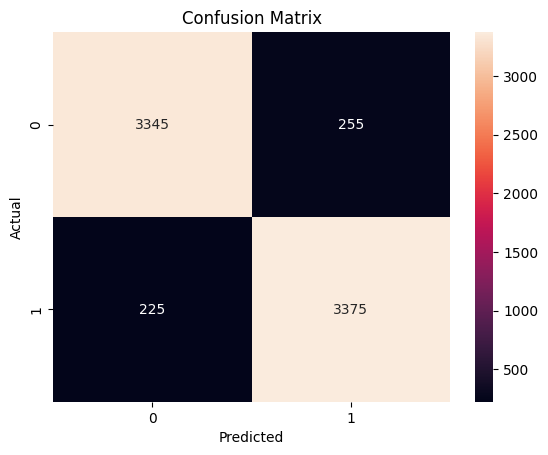

Accuracy: 0.9333333333333333
Precision: 0.9369747899159664
Recall: 0.9291666666666667
F1-Score: 0.9330543933054394
Kappa Coefficient: 0.8666666666666667


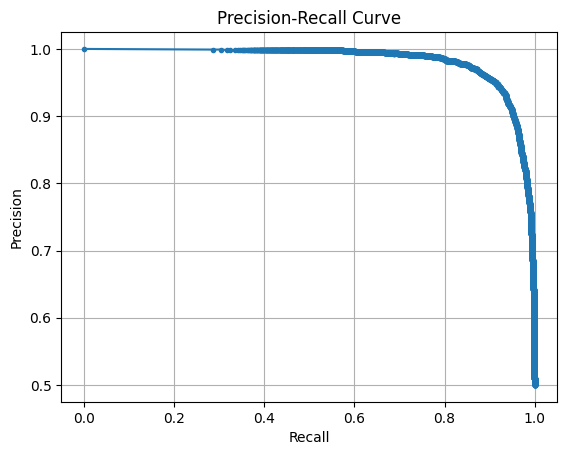

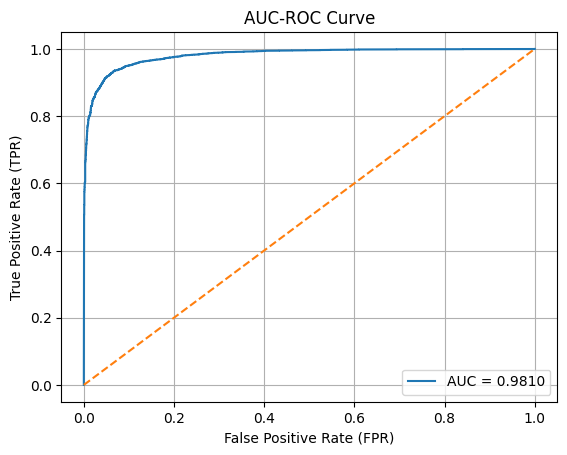

In [12]:
#########################################
# Coded By: Brandon Ting En Junn 2101751
#########################################
# Initialise model evaluator
model_evaluator = ModelEvaluator(model=model, data_loader=test_loader)

# Output evaluation
model_evaluator.summary()

## 5. Save Model

In [13]:
#########################################
# Coded By: Brandon Ting En Junn 2101751
#########################################
# Save model
torch.save(model, "model.pth")